In [50]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import math
import scipy
from scipy.special import erf
import numpy
from numpy import exp
from numpy.lib.scimath import log, sqrt
from mpl_toolkits.mplot3d import Axes3D

In [100]:
plt.rcParams.update({'font.size': 15})
plt.rcParams["figure.figsize"] = (13, 7)


## Exercise 6.01 ##
In this notebook we will explore numerically the properties of the 1d Ising model. The Ising model is a toy model for ferromagnetism, widely used as a paradigmatic example in statistical mechanics.

We have a set $\sigma_i$ of  spins: each spin can assume two values($1$ and $-1$) and it interacts only with the two nearest neighbours thorgh a coupling constant $J$. The hamiltonian of the system is given by
$$H=-J\sum_{i}\sigma_{i}\sigma_{i+1}-h\sum_{i}\sigma_{\{i\}}$$
where $J$ is a coupling constant and $h$ is the external applied field. All the thermodynamical properties can be obtained by deriving the partition function:
$$Z=\sum_{\{\sigma_i\}}e^{-\beta H({\sigma_i})}$$

We will use two methods to sample from the configuration space: the Metropolis-Hastings algorithm and the Gibbs sampling

To make one Monte Carlo step  with the Metropolis-Hastings algorithm we do the following:
- we choose a random integer $j$ between $0$ and the number of spins $N$
- we calculate the relative probability of $s[j]=1$ or $s[j]=-1$, which are given by the boltzmann weight, and we calculate the ratio $r$ of the probability of the system with the spin flipped and the probability of the system with the current spin
- we choose a random number $X$ uniformly distributed from $[0,1]$ and we flip the spin $j$ if $X<r$ 
- we repeat the previous three steps $N$ times

While one Monte Carlo step with the Gibbs sampling consists in:
- we choose a random integer $j$ between $0$ and the number of spins $N$
- we calculate the marginal probability $p$ of $s[j]=1$, which is given by the boltzmann weight 
$$p(s[j]=1)=\frac{p(s_j=1|s_1...s_n)}{p(s_j=1|s_1...s_n)+p(s_j=-1|s_1 ...s_n)}$$
- we choose a random number $X$ uniformly distributed from $[0,1]$ and we set $s[j]=1$ if $X<p$, or we set $s[j]=-1$ otherwise
- we repeat the previous three steps $N$ times

The main difference between the two methods is that with the Gibbs sampling we don't use the current state of the spin $j$. The two methods are equivalent, and it can be shown that the Gibbs sampling is a Metropolis Sampling in which the proposed move is always accepted.
In both cases one Monte Carlo step means a number of spin flips of the order of the number of spins,

Before the start of the simulations we need to perform the equilibration to get a reasonable state for the temperature we want: to do so we start with a chain of spins up and we perform $1000$ step:

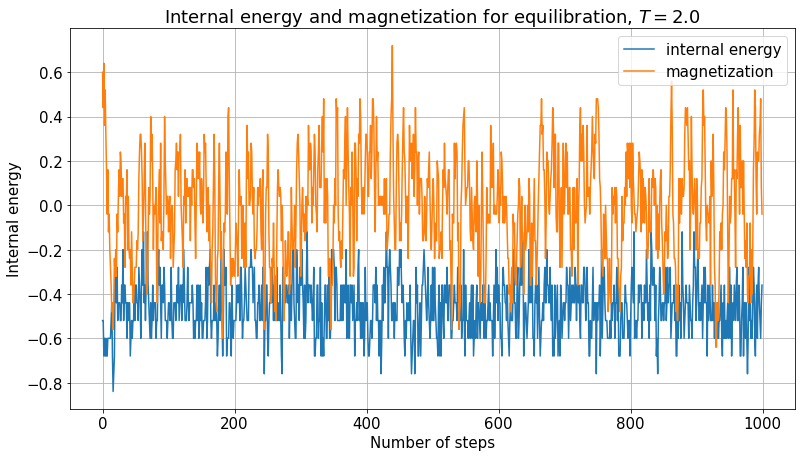

In [138]:
df1=pd.read_fwf(r'./Ising_1D2/equilibrationData/output.ene.0',header=None,nrows_infer=10010)
df2=pd.read_fwf(r'./Ising_1D2/equilibrationData/output.mag.0',header=None,nrows_infer=10010)
df1.columns=['nBlocks','estimate','avg','err']
df2.columns=['nBlocks','estimate','avg','err']
plt.plot(df1.estimate, label="internal energy")
plt.plot(df2.estimate, label="magnetization")
plt.title(r'Internal energy and magnetization for equilibration, $T=2.0$')
plt.xlabel('Number of steps')
plt.ylabel('Internal energy')
plt.grid();
plt.legend();

As we can see the equilibration is basically instantaneous: even if we start from a 0 energy configuration at the end of the first Monte Carlo step we already are at the equilibrium value.

In the next three blocks we are plotting the results of Montecarlo simulations of a one-dimensional Ising model along with the theoretical results.

Each value is calculated for 30 values of $T$ ranging from $0.5$ to $2.0$  on a chain of $50$ spins, by performing a Monte Carlo simulation of the system. To compute the statistical uncertainties we used datablocking with a block size of $1000$, and we used $100$ blocks, and we took the value of the $100$-th block and its uncertainty.

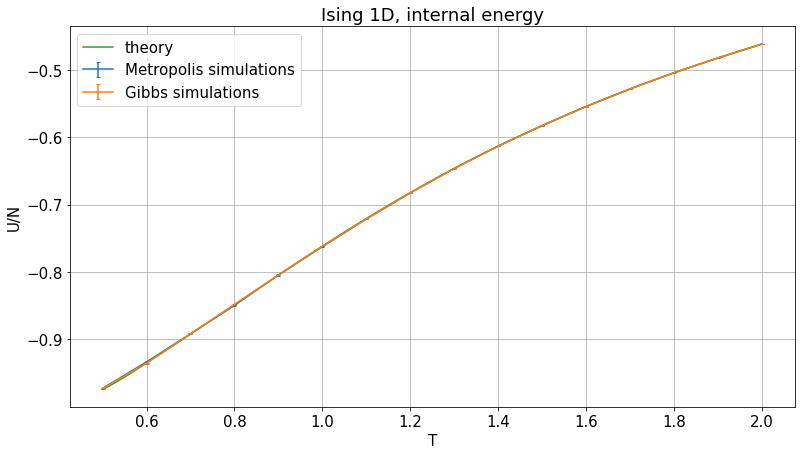

In [159]:
df1=pd.read_csv(r'./Ising_1D2/finalDataMetropolis/outputEnergyTemp.csv')
df2=pd.read_csv(r'./Ising_1D2/finalDataGibbs/outputEnergyTemp.csv')
plt.errorbar(x=df1.temp,y=df1.finalEnergy,yerr=df1.err,capsize=2, label="Metropolis simulations")
plt.errorbar(x=df2.temp,y=df2.finalEnergy,yerr=df2.err,capsize=2, label="Gibbs simulations")
points=100
T = np.linspace(0.5,2.0,num=points)
beta = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
ch = 1/th
e = -J*( th + ch*thN )/( 1 + thN )
plt.plot(T, e, label="theory")
plt.title('Ising 1D, internal energy')
plt.xlabel('T')
plt.ylabel('U/N')
plt.grid()
plt.legend();

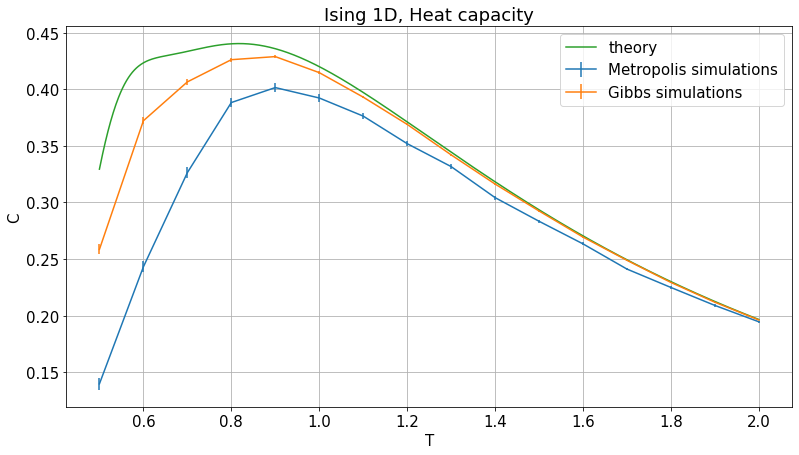

In [129]:
df1=pd.read_csv(r'./Ising_1D2/outputHeatTemp.csv')
df2=pd.read_csv(r'./Ising_1D2/finalDataGibbs/outputHeatTemp.csv')
plt.errorbar(x=df1.temp,y=df1.finalHeat,yerr=df1.err, label="Metropolis simulations")
plt.errorbar(x=df2.temp,y=df2.finalHeat,yerr=df2.err, label="Gibbs simulations")
points=1000
T = np.linspace(0.5,2.0,num=points)
beta = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
ch = 1/th
heat=((beta*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)
plt.plot(T, heat, label='theory')
plt.title('Ising 1D, Heat capacity')
plt.xlabel('T')
plt.ylabel('C')
plt.grid()
plt.legend();

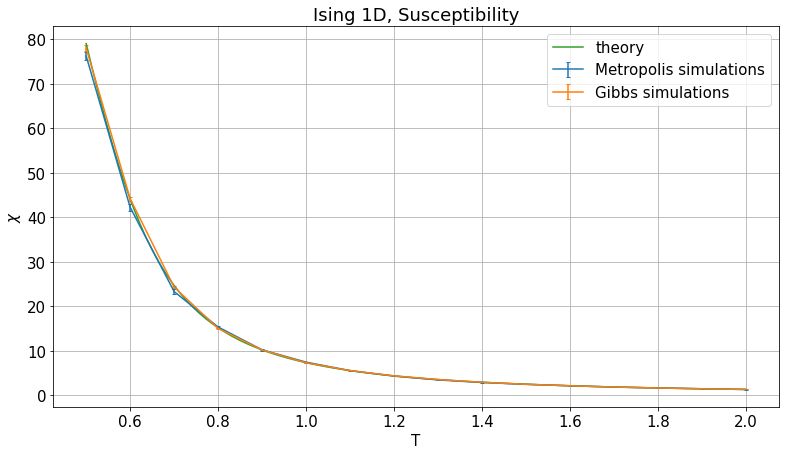

In [177]:
df1=pd.read_csv(r'./Ising_1D2/finalDataMetropolis/outputChiTemp.csv')
df2=pd.read_csv(r'./Ising_1D2/finalDataGibbs/outputChiTemp.csv')
plt.errorbar(x=df1.temp,y=df1.finalChi,yerr=df1.err,capsize=2, label="Metropolis simulations")
plt.errorbar(x=df2.temp,y=df2.finalChi,yerr=df2.err,capsize=2, label="Gibbs simulations")
points=100
T = np.linspace(0.5,2.0,num=points)
beta = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
ch = 1/th
X = beta*np.exp(2*beta*J)*(1-thN)/(1+thN)
plt.plot(T, X, label='theory')
plt.title('Ising 1D, Susceptibility')
plt.xlabel('T')
plt.ylabel(r'$\chi$')
plt.grid()
plt.legend();

These results are interesting. All the results are plotted with the error bars, and there is a good agreement with the theoretical result, except for the heat capacity at low temperature. To explore the reason of this we can study the instant value of the magnetization and the internal energy at low temperature:

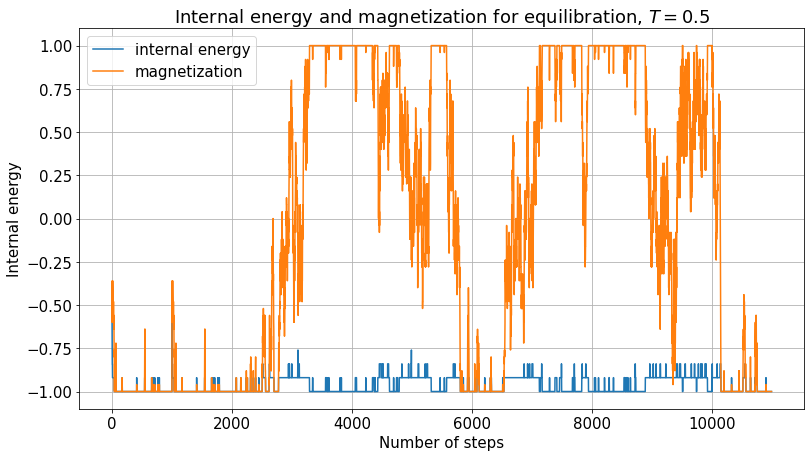

In [161]:
df1=pd.read_fwf(r'./Ising_1D2/equilibrationDataLowtemp/output.ene.0',header=None,nrows_infer=10010)
df2=pd.read_fwf(r'./Ising_1D2/equilibrationDataLowtemp/output.mag.0',header=None,nrows_infer=10010)
df1.columns=['nBlocks','estimate','avg','err']
df2.columns=['nBlocks','estimate','avg','err']
plt.plot(df1.estimate, label="internal energy")
plt.plot(df2.estimate, label="magnetization")
plt.title(r'Internal energy and magnetization for equilibration, $T=0.5$')
plt.xlabel('Number of steps')
plt.ylabel('Internal energy')
plt.grid();
plt.legend();

While there is no net magnetization over time, the system stays in a magnetized state for $\approx 2000$ steps. So in our blocks of $1000$ steps there is a net magnetization, which is in contrast with the theory. We could also see this by studying the acceptance rate: at $T\approx 0.5$. We can obviously try to produce better results by augmenting the size of the block to $10^5$. 

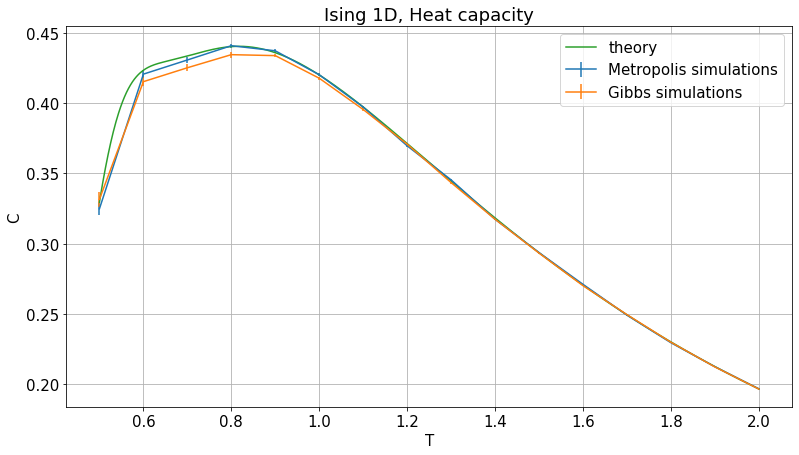

In [162]:
df1=pd.read_csv(r'./Ising_1D2/finalDataMetropolisPrecise/outputHeatTemp.csv')
df2=pd.read_csv(r'./Ising_1D2/finalDataGibbsPrecise/outputHeatTemp.csv')
plt.errorbar(x=df1.temp,y=df1.finalHeat,yerr=df1.err, label="Metropolis simulations")
plt.errorbar(x=df2.temp,y=df2.finalHeat,yerr=df2.err, label="Gibbs simulations")
points=1000
T = np.linspace(0.5,2.0,num=points)
beta = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
ch = 1/th
heat=((beta*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)
plt.plot(T, heat, label='theory')
plt.title('Ising 1D, Heat capacity')
plt.xlabel('T')
plt.ylabel('C')
plt.grid()
plt.legend();

The results better fit the theory, but the gibbs sampling is still incompatible with the theory. In fact the error bar at low temperature are wrong: as we saw the system is strongly correlated, and the uncertainty is underestimated. 

We can't study the magnetization in a zero field setting, because there's no spontaneous magnetization at finite temperature in one dimension(see the Peierls argument), and we therefore decided to study the magnetization with a field of $0.02$. For a reason we are not able to explain, the statistical uncertainties are much bigger, and we have to sample $1000$ blocks of $1000$ steps to see a satisfying result

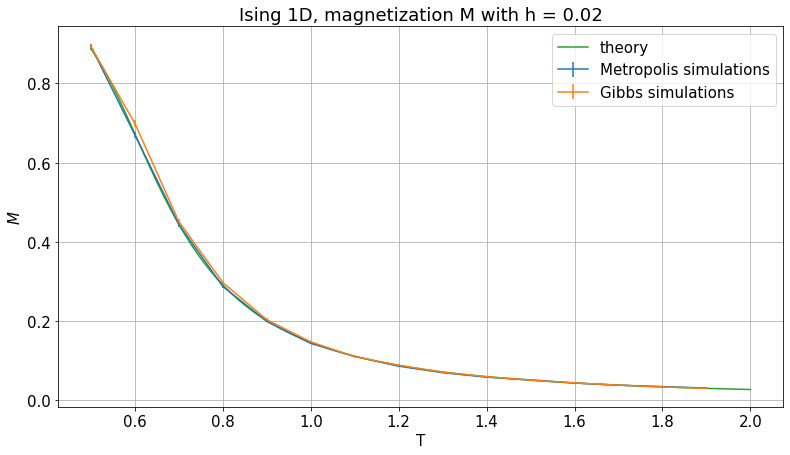

In [178]:
df1=pd.read_csv(r'./Ising_1D2/finalDataMetropolis/outputMagTempField.csv')
df2=pd.read_csv(r'./Ising_1D2/finalDataGibbs/outputMagTempField.csv')
plt.errorbar(x=df1.temp,y=df1.finalMag,yerr=df1.err, label="Metropolis simulations")
plt.errorbar(x=df2.temp,y=df2.finalMag,yerr=df2.err, label="Gibbs simulations")
points=100
T = np.linspace(0.5,2.0,num=points)
beta = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
ch = 1/th

h=0.02 #external field
b = 1/T

l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
Z = l1**Ns + l2**Ns
M = (np.exp(b*J)*np.sinh(b*h)*((l1**(Ns-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
        + (l2**(Ns-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z)
plt.plot(T, M , label='theory')
plt.title('Ising 1D, magnetization M with h = 0.02')
plt.xlabel('T')
plt.ylabel('$M$')
plt.legend();
plt.grid()
plt.show();

## Energy and magnetization autocorrelation for low T ##

Here we plot the autocorrelation for the internal energy and the magnetization at low $T$ to give a quantitative basis of what has been said so far:

In [172]:
def selfCorrelation(ts,r):
    selfCorrelations = []
    meanR=np.mean(r)
    variance=np.var(r)
    r=np.array(r-meanR)
    for t in ts:
        selfCorrelations.append(np.sum([((r[i]*r[i+t])/(len(r)-t)) for i in range(1,len(r)-t)]))
    selfCorrelations=np.array(selfCorrelations)/variance
    return selfCorrelations

In [ ]:
df1=pd.read_fwf(r'./Ising_1D2/equilibrationDataLowtemp/output.ene.0',header=None,nrows_infer=10010)
df2=pd.read_fwf(r'./Ising_1D2/equilibrationDataLowtemp/output.mag.0',header=None,nrows_infer=10010)
df1.columns=['nBlocks','estimate','avg','err']
df2.columns=['nBlocks','estimate','avg','err']
ene=df1.estimate
mag=df2.estimate
t=range(0,7000)
autocorrs=[]
selfcorrEne= selfCorrelation(t,ene);
selfcorrMag= selfCorrelation(t,mag);
plt.xlabel(r'$\Delta t$')
plt.ylabel('autocorrelation')
plt.plot(selfcorrEne,label='energy');

plt.plot(selfcorrMag,label='magnetization');
plt.title('Autocorrelation, metropolis algorithm, T=0.5');
plt.legend()
plt.grid()
plt.show();

## Comments and conclusion ##
The results showed in this notebook may be improved in at least two ways: by providing a study of autocorrelation at different temperatures to be sure that the blocks are really independents and that the uncertainties aren't underestimated, and the introduction of a more clever jumping technique (for example the introduction of the cluster moves) to avoid the non-egodicity we experienced at low temperature. 